In [8]:
# HIDDEN
import matplotlib
#matplotlib.use('Agg')
from datascience import *
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import math
import scipy.stats as stats
plt.style.use('fivethirtyeight')

### Implementing Nearest Neighbor Classifiers ###
Do this one with the wine data. Text will need to be adjusted accordingly.

### Applying the k-nearest neighbor classifier to breast cancer diagnosis

We've got a data set.  Let's try out the $k$-nearest neighbor classifier and see how it does.  This is going to be great.

We're going to need an implementation of the $k$-nearest neighbor classifier.  In practice you would probably use an existing library, but it's simple enough that I'm going to imeplment it myself.

The first thing we need is a way to compute the distance between two points.  How do we do this?  In 2-dimensional space, it's pretty easy.  If we have a point at coordinates $(x_0,y_0)$ and another at $(x_1,y_1)$, the distance between them is

$$D = \sqrt{(x_0-x_1)^2 + (y_0-y_1)^2}.$$

(Where did this come from?  It comes from the Pythogorean theorem: we have a right triangle with side lengths $x_0-x_1$ and $y_0-y_1$, and we want to find the length of the diagonal.)

In 3-dimensional space, the formula is

$$D = \sqrt{x_0-x_1)^2 + (y_0-y_1)^2 + (z_0-z_1)^2}.$$

In $k$-dimensional space, things are a bit harder to visualize, but I think you can see how the formula generalized: we sum up the squares of the differences between each individual coordinate, and then take the square root of that.  Let's implement a function to compute this distance function for us:

In [9]:
def distance(pt1, pt2):
    total = 0
    for i in np.arange(len(pt1)):
        total = total + (pt1.item(i) - pt2.item(i))**2
    return math.sqrt(total)

Next, we're going to write some code to implement the classifier.  The input is a patient `p` who we want to diagnose.  The classifier works by finding the $k$ nearest neighbors of `p` from the training set.  So, our approach will go like this:

1. Find the closest $k$ neighbors of `p`, i.e., the $k$ patients from the training set that are most similar to `p`.

2. Look at the diagnoses of those $k$ neighbors, and take the majority vote to find the most-common diagnosis.  Use that as our predicted diagnosis for `p`.

So that will guide the structure of our Python code.

To implement the first step, we will compute the distance from each patient in the training set to `p`, sort them by distance, and take the $k$ closest patients in the training set.  The code will make a copy of the table, compute the distance from each patient to `p`, add a new column to the table with those distances, and then sort the table by distance and take the first $k$ rows.  That leads to the following Python code:

In [10]:
def closest(training, p, k):
    ...

def majority(topkclasses):
    ...

def classify(training, p, k):
    kclosest = closest(training, p, k)
    kclosest.classes = kclosest.select('Class')
    return majority(kclosest)

In [11]:
def computetablewithdists(training, p):
    dists = np.zeros(training.num_rows)
    attributes = training.drop('Class')
    for i in np.arange(training.num_rows):
        dists[i] = distance(attributes.row(i), p)
    return training.with_column('Distance', dists)

def closest(training, p, k):
    withdists = computetablewithdists(training, p)
    sortedbydist = withdists.sort('Distance')
    topk = sortedbydist.take(np.arange(k))
    return topk

def majority(topkclasses):
    if topkclasses.where('Class', 1).num_rows > topkclasses.where('Class', 0).num_rows:
        return 1
    else:
        return 0

def classify(training, p, k):
    closestk = closest(training, p, k)
    topkclasses = closestk.select('Class')
    return majority(topkclasses)

Let's see how this works, with our data set.  We'll take patient 12 and imagine we're going to try to diagnose them:

In [12]:
patients = Table.read_table('breast-cancer.csv').drop('ID')
patients

Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
5,1,1,1,2,1,3,1,1,0
5,4,4,5,7,10,3,2,1,0
3,1,1,1,2,2,3,1,1,0
6,8,8,1,3,4,3,7,1,0
4,1,1,3,2,1,3,1,1,0
8,10,10,8,7,10,9,7,1,1
1,1,1,1,2,10,3,1,1,0
2,1,2,1,2,1,3,1,1,0
2,1,1,1,2,1,1,1,5,0
4,2,1,1,2,1,2,1,1,0


In [13]:
patients.take(12)

Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
5,3,3,3,2,3,4,4,1,1


We can pull out just their attributes (excluding the class), like this:

In [14]:
patients.drop('Class').row(12)

Row(Clump Thickness=5, Uniformity of Cell Size=3, Uniformity of Cell Shape=3, Marginal Adhesion=3, Single Epithelial Cell Size=2, Bare Nuclei=3, Bland Chromatin=4, Normal Nucleoli=4, Mitoses=1)

Let's take $k=5$.  We can find the 5 nearest neighbors:

In [15]:
closest(patients, patients.drop('Class').row(12), 5)

Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class,Distance
5,3,3,3,2,3,4,4,1,1,0
5,3,3,4,2,4,3,4,1,1,1.73205
5,1,3,3,2,2,2,3,1,0,3.16228
5,2,2,2,2,2,3,2,2,0,3.16228
5,3,3,1,3,3,3,3,3,1,3.31662


3 out of the 5 nearest neighbors have class 1, so the majority is 1 (has cancer) -- and that is the output of our classifier for this patient:

In [16]:
classify(patients, patients.drop('Class').row(12), 5)

1

Awesome!  We now have a classification algorithm for diagnosing whether a patient has breast cancer or not, based on the measurements from the lab.  Are we done?  Shall we give this to doctors to use?

Hold on: we're not done yet.  There's an obvious question to answer, before we start using this in practice:

*How accurate is this method, at diagnosing breast cancer?*

And that raises a more fundamental issue.  How can we measure the accuracy of a classification algorithm?

In [17]:
""" REDONE STUFF"""

def distance2(pt1, pt2):
    return np.sqrt(np.sum((pt1 - pt2)**2))

def distance_from_individual(attribute_table, i, p):
    """Need to explain .row,
    and that we can make it an array here as it's all numerical"""
    return distance2(make_array(attribute_table.row(i)), p)

def table_with_dists2(training, p):
    """Redone to resemble other such code in the course."""
    dists = make_array()
    attributes = training.drop('Class')
    for i in np.arange(training.num_rows):
        dists = np.append(dists, distance_from_individual(attributes, i , p))
    return training.with_column('Distance', dists)

def closest2(training, p, k):
    with_dists = table_with_dists2(training, p)
    sorted_by_dist = with_dists.sort('Distance')
    topk = sorted_by_dist.take(np.arange(k))
    return topk

def majority(topkclasses):
    ones = topkclasses.where('Class', are.equal_to(1)).num_rows
    zeros = topkclasses.where('Class', are.equal_to(0)).num_rows
    if ones > zeros:
        return 1
    else:
        return 0

def classify2(training, p, k):
    closestk = closest2(training, p, k)
    topkclasses = closestk.select('Class')
    return majority(topkclasses)

In [18]:
n = 12

In [19]:
point = make_array(patients.drop('Class').row(12))
point

array([[5, 3, 3, 3, 2, 3, 4, 4, 1]])

In [20]:
closest2(patients, point, 5)

Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class,Distance
5,3,3,3,2,3,4,4,1,1,0
5,3,3,4,2,4,3,4,1,1,1.73205
5,1,3,3,2,2,2,3,1,0,3.16228
5,2,2,2,2,2,3,2,2,0,3.16228
5,3,3,1,3,3,3,3,3,1,3.31662


In [21]:
classify2(patients, point, 5)

1

In [22]:
patients.row(n)

Row(Clump Thickness=5, Uniformity of Cell Size=3, Uniformity of Cell Shape=3, Marginal Adhesion=3, Single Epithelial Cell Size=2, Bare Nuclei=3, Bland Chromatin=4, Normal Nucleoli=4, Mitoses=1, Class=1)

### Measuring accuracy of a classifier

We've got a classifier, and we'd like to determine how accurate it will be.  How can we measure that?

**Try it out.**  One natural idea is to just try it on patients for a year, keep records on it, and see how accurate it is.  However, this has some disadvantages: (a) we're trying something on patients without knowing how accurate it is, which might be unethical; (b) we have to wait a year to find out whether our classifier is any good.  If it's not good enough and we get an idea for an improvement, we'll have to wait another year to find out whether our improvement was better.

**Get some more data.** We could try to get some more data from other patients whose diagnosis is known, and measure how accurate our classifier's predictions are on those additional patients.  We can compare what the classifier outputs against what we know to be true.

**Use the data we already have.** Another natural idea is to re-use the data we already have: we have a training set that we used to train our classifier, so we could just run our classifier on every patient in the data set and compare what it outputs to what we know to be true.  This is sometimes known as testing the classifier on your training set.

How should we choose among these options?  Are they all equally good?

It turns out that the third option, testing the classifier on our training set, is fundamentally flawed.  It might sound attractive, but it gives misleading results: it will over-estimate the accuracy of the classifier (it will make us think the classifier is more accurate than it really is).  Intuitively, the problem is that what we really want to know is how well the classifier has done at "generalizing" beyond the specific examples in the training set; but if we test it on patients from the training set, then we haven't learned anything about how well it would generalize to other patients.

This is subtle, so it might be helpful to try an example.  Let's try a thought experiment.  Let's focus on the 1-nearest neighbor classifier ($k=1$).  Suppose you trained the 1-nearest neighbor classifier on data from all 683 patients in the data set, and then you tested it on those same 683 patients.  How many would it get right?  Think it through and see if you can work out what will happen.  That's right!  The classifier will get the right answer for all 683 patients.  Suppose we apply the classifier to a patient from the training set, say Alice.  The classifier will look for the nearest neighbor (the most similar patient from the training set), and the nearest neighbor will turn out to be Alice herself (the distance from any point to itself is zero).  Thus, the classifier will produce the right diagnosis for Alice.  The same reasoning applies to every other patient in the training set.

So, if we test the 1-nearest neighbor classifier on the training set, the accuracy will always be 100%: absolutely perfect.  This is true no matter whether there are actually any patterns in the data.  But the 100% is a total lie.  When you apply the classifier to other patients who were not in the training set, the accuracy could be far worse.

In other words, testing on the training tells you nothing about how accurate the 1-nearest neighbor classifier will be.  This illustrates why testing on the training set is so flawed.  This flaw is pretty blatant when you use the 1-nearest neighbor classifier, but don't think that with some other classifier you'd be immune to this problem -- the problem is fundamental and applies no matter what classifier you use.  Testing on the training set gives you a biased estimate of the classifier's accurate.  For these reasons, you should never test on the training set.

So what *should* you do, instead?  Is there a more principled approach?

It turns out there is.  The approach comes down to: get more data.  More specifically, the right solution is to use one data set for training, and a different data set for testing, with no overlap between the two data sets.  We call these a *training set* and a *test set*.

Where do we get these two data sets from?  Typically, we'll start out with some data, e.g., the data set on 683 patients, and before we do anything else with it, we'll split it up into a training set and a test set.  We might put 50% of the data into the training set and the other 50% into the test set.  Basically, we are setting aside some data for later use, so we can use it to measure the accuracy of our classifier.  Sometimes people will call the data that you set aside for testing a *hold-out set*, and they'll call this strategy for estimating accuracy the *hold-out method*.

Note that this approach requires great discipline.  Before you start applying machine learning methods, you have to take some of your data and set it aside for testing.  You must avoid using the test set for developing your classifier: you shouldn't use it to help train your classifier or tweak its settings or for brainstorming ways to improve your classifier.  Instead, you should use it only once, at the very end, after you've finalized your classifier, when you want an unbiased estimate of its accuracy.

## The effectiveness of our classifier, for breast cancer

OK, so let's apply the hold-out method to evaluate the effectiveness of the $k$-nearest neighbor classifier for breast cancer diagnosis.  The data set has 683 patients, so we'll randomly permute the data set and put 342 of them in the training set and the remaining 341 in the test set.

In [23]:
""" REDONE STUFF: 
due to new default of sample
and not over-writing patients table after shuffling"""
shuffled_patients = patients.sample(683, with_replacement=False) # Randomly permute the rows
trainset = shuffled_patients.take(range(342))
testset  = shuffled_patients.take(range(342, 683))

We'll train the classifier using the 342 patients in the training set, and evaluate how well it performs on the test set.  To make our lives easier, we'll write a function to evaluate a classifier on every patient in the test set:

In [24]:
def evaluate_accuracy(training, test, k):
    testattrs = test.drop('Class')
    numcorrect = 0
    for i in range(test.num_rows):
        # Run the classifier on the ith patient in the test set
        c = classify(training, testattrs.rows[i], k)
        # Was the classifier's prediction correct?
        if c == test.column('Class').item(i):
            numcorrect = numcorrect + 1
    return numcorrect / test.num_rows

Now for the grand reveal -- let's see how we did.  We'll arbitrarily use $k=5$.

In [25]:
evaluate_accuracy(trainset, testset, 5)

0.9706744868035191

About 96% accuracy.  Not bad!  Pretty darn good for such a simple technique.

As a footnote, you might have noticed that Brittany Wenger did even better.  What techniques did she use? One key innovation is that she incorporated a confidence score into her results: her algorithm had a way to determine when it was not able to make a confident prediction, and for those patients, it didn't even try to predict their diagnosis.  Her algorithm was 99% accurate on the patients where it made a prediction -- so that extension seemed to help quite a bit.

In [26]:
""" REDONE STUFF:
To separate out two main bits
and turn rows into arrays"""

def count_zero(array):
    return len(array) - np.count_nonzero(array)

def count_equal(array1, array2):
    """Takes two numerical arrays of equal length
    and counts the indices where the two are equal"""
    return count_zero(array1 - array2)

def evaluate_accuracy2(training, test, k):
    test_attributes = test.drop('Class')
    c = make_array()
    for i in range(test.num_rows):
        # Run the classifier on the ith patient in the test set
        c = np.append(c, classify(training, make_array(test_attributes.row(i)), k))   
    return count_equal(c, test.column('Class')) / test.num_rows

In [27]:
evaluate_accuracy2(trainset, testset, 5)

0.9706744868035191

### Important takeaways

Here are a few lessons we want you to learn from this.

First, machine learning is powerful.  If you had to try to write code to make a diagnosis without knowing about machine learning, you might spend a lot of time by trial-and-error trying to come up with some complicated set of rules that seem to work, and the result might not be very accurate.  The $k$-nearest neighbors algorithm automates the entire task for you.  And machine learning often lets them make predictions far more accurately than anything you'd come up with by trial-and-error.

Second, you can do it.  Yes, you.  You can use machine learning in your own work to make predictions based on data.  You now know enough to start applying these ideas to new data sets and help others make useful predictions.  The techniques are very powerful, but you don't have to have a Ph.D. in statistics to use them.

Third, be careful about how to evaluate accuracy.  Use a hold-out set.

There's lots more one can say about machine learning: how to choose attributes, how to choose $k$ or other parameters, what other classification methods are available, how to solve more complex prediction tasks, and lots more.  In this course, we've barely even scratched the surface.  If you enjoyed this material, you might enjoy continuing your studies in statistics and computer science; courses like Stats 132 and 154 and CS 188 and 189 go into a lot more depth.

### Worth Including? ###
Approx 90% accuracy. All the variables are continuous, as opposed to ordinal as many of the breast cancer variables are. I'm tempted to make this one the first example, though classifying wines isn't as important as classifying cells for cancer.

In [28]:
wine = Table.read_table('wine.csv')

In [29]:
# Note there are three Class values: 1, 2, 3
wine

Class,Alcohol,Malic Acid,Ash,Alcalinity of Ash,Magnesium,Total Phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color Intensity,Hue,OD280/OD315 of diulted wines,Proline
1,14.23,1.71,2.43,15.6,127,2.8,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,13.2,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.4,1050
1,13.16,2.36,2.67,18.6,101,2.8,3.24,0.3,2.81,5.68,1.03,3.17,1185
1,14.37,1.95,2.5,16.8,113,3.85,3.49,0.24,2.18,7.8,0.86,3.45,1480
1,13.24,2.59,2.87,21,118,2.8,2.69,0.39,1.82,4.32,1.04,2.93,735
1,14.2,1.76,2.45,15.2,112,3.27,3.39,0.34,1.97,6.75,1.05,2.85,1450
1,14.39,1.87,2.45,14.6,96,2.5,2.52,0.3,1.98,5.25,1.02,3.58,1290
1,14.06,2.15,2.61,17.6,121,2.6,2.51,0.31,1.25,5.05,1.06,3.58,1295
1,14.83,1.64,2.17,14,97,2.8,2.98,0.29,1.98,5.2,1.08,2.85,1045
1,13.86,1.35,2.27,16,98,2.98,3.15,0.22,1.85,7.22,1.01,3.55,1045


In [30]:
# For converting Class to binary

def is_one(x):
    if x == 1:
        return 1
    else:
        return 0

In [31]:
wine1 = wine.with_column('Class', wine.apply(is_one, 0))

In [32]:
wine1.show()

Class,Alcohol,Malic Acid,Ash,Alcalinity of Ash,Magnesium,Total Phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color Intensity,Hue,OD280/OD315 of diulted wines,Proline
1,14.23,1.71,2.43,15.6,127,2.8,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,13.2,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.4,1050
1,13.16,2.36,2.67,18.6,101,2.8,3.24,0.3,2.81,5.68,1.03,3.17,1185
1,14.37,1.95,2.5,16.8,113,3.85,3.49,0.24,2.18,7.8,0.86,3.45,1480
1,13.24,2.59,2.87,21,118,2.8,2.69,0.39,1.82,4.32,1.04,2.93,735
1,14.2,1.76,2.45,15.2,112,3.27,3.39,0.34,1.97,6.75,1.05,2.85,1450
1,14.39,1.87,2.45,14.6,96,2.5,2.52,0.3,1.98,5.25,1.02,3.58,1290
1,14.06,2.15,2.61,17.6,121,2.6,2.51,0.31,1.25,5.05,1.06,3.58,1295
1,14.83,1.64,2.17,14,97,2.8,2.98,0.29,1.98,5.2,1.08,2.85,1045
1,13.86,1.35,2.27,16,98,2.98,3.15,0.22,1.85,7.22,1.01,3.55,1045


In [33]:
shuffled_wine = wine1.sample(with_replacement=False) 
trainset = shuffled_wine.take(np.arange(90))
testset  = shuffled_wine.take(np.arange(91, 178))

In [34]:
evaluate_accuracy2(trainset, testset, 5)

0.9195402298850575

In [51]:
t_color = Table().with_columns(
    'Class', make_array(0, 1),
    'Color', make_array('darkblue', 'gold')
)
t_new = wine1.join('Class', t_color)

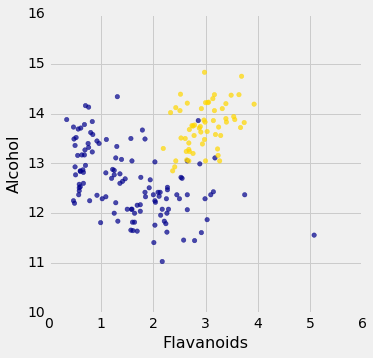

In [54]:
t_new.scatter(7, 1, colors='Color')

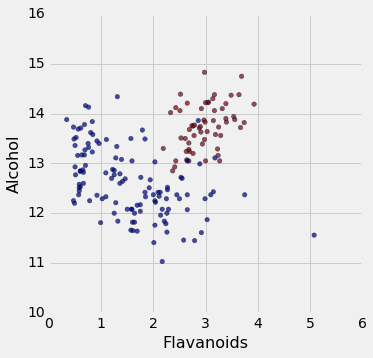

In [35]:
wine1.scatter(7, 1, c=wine1.column('Class'))